# Stock Index prediction

Stock price movement is driven by fundamental and technical analysis.  In this project we aim to predict the prices using technical analysis

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (20,10)

5 Year historical S&P500 prices downloaded from www.yahoo.com.

In [34]:
#Read the file
spx = pd.read_csv('spx.csv')
spx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-07,1770.739990,1774.540039,1746.199951,1747.150024,1747.150024,4143200000
1,2013-11-08,1748.369995,1770.780029,1747.630005,1770.609985,1770.609985,3837170000
2,2013-11-11,1769.959961,1773.439941,1767.849976,1771.890015,1771.890015,2534060000
3,2013-11-12,1769.510010,1771.780029,1762.290039,1767.689941,1767.689941,3221030000
4,2013-11-13,1764.369995,1782.000000,1760.640015,1782.000000,1782.000000,3327480000


* Columns *Open* and *Close* are the starting and ending prices of the day
* Columns *High* and *Low* are the highest and lowest prices of the day
* Column *Volume* is the total number of shares traded (that belonged to the S&P500 index)
* Column *Adj Close* is the adjusted closing price of the day.  It is usually same as the closing price of the day. 

In [35]:
# Let's make sure Close and Adj Close columns are same
(spx['Close'] == spx['Adj Close']).sum() == spx.shape[0]

True

In [36]:
# Adj Close column can be dropped
spx.drop('Adj Close', axis=1, inplace=True)

In [37]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
Date      1259 non-null object
Open      1259 non-null float64
High      1259 non-null float64
Low       1259 non-null float64
Close     1259 non-null float64
Volume    1259 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [38]:
# The column *Date* is in 'Object' format.  
# It needs to be changed to DateTime format

spx['Date'] = pd.to_datetime(spx['Date'], format='%Y-%m-%d')

#  Date is also set as index
spx.index = spx['Date']

In [39]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-11-07 to 2018-11-06
Data columns (total 6 columns):
Date      1259 non-null datetime64[ns]
Open      1259 non-null float64
High      1259 non-null float64
Low       1259 non-null float64
Close     1259 non-null float64
Volume    1259 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 68.9 KB


**Profit / Loss is determined using the closing price of the stock or index.  Hence we will make *Close* as the target variable**

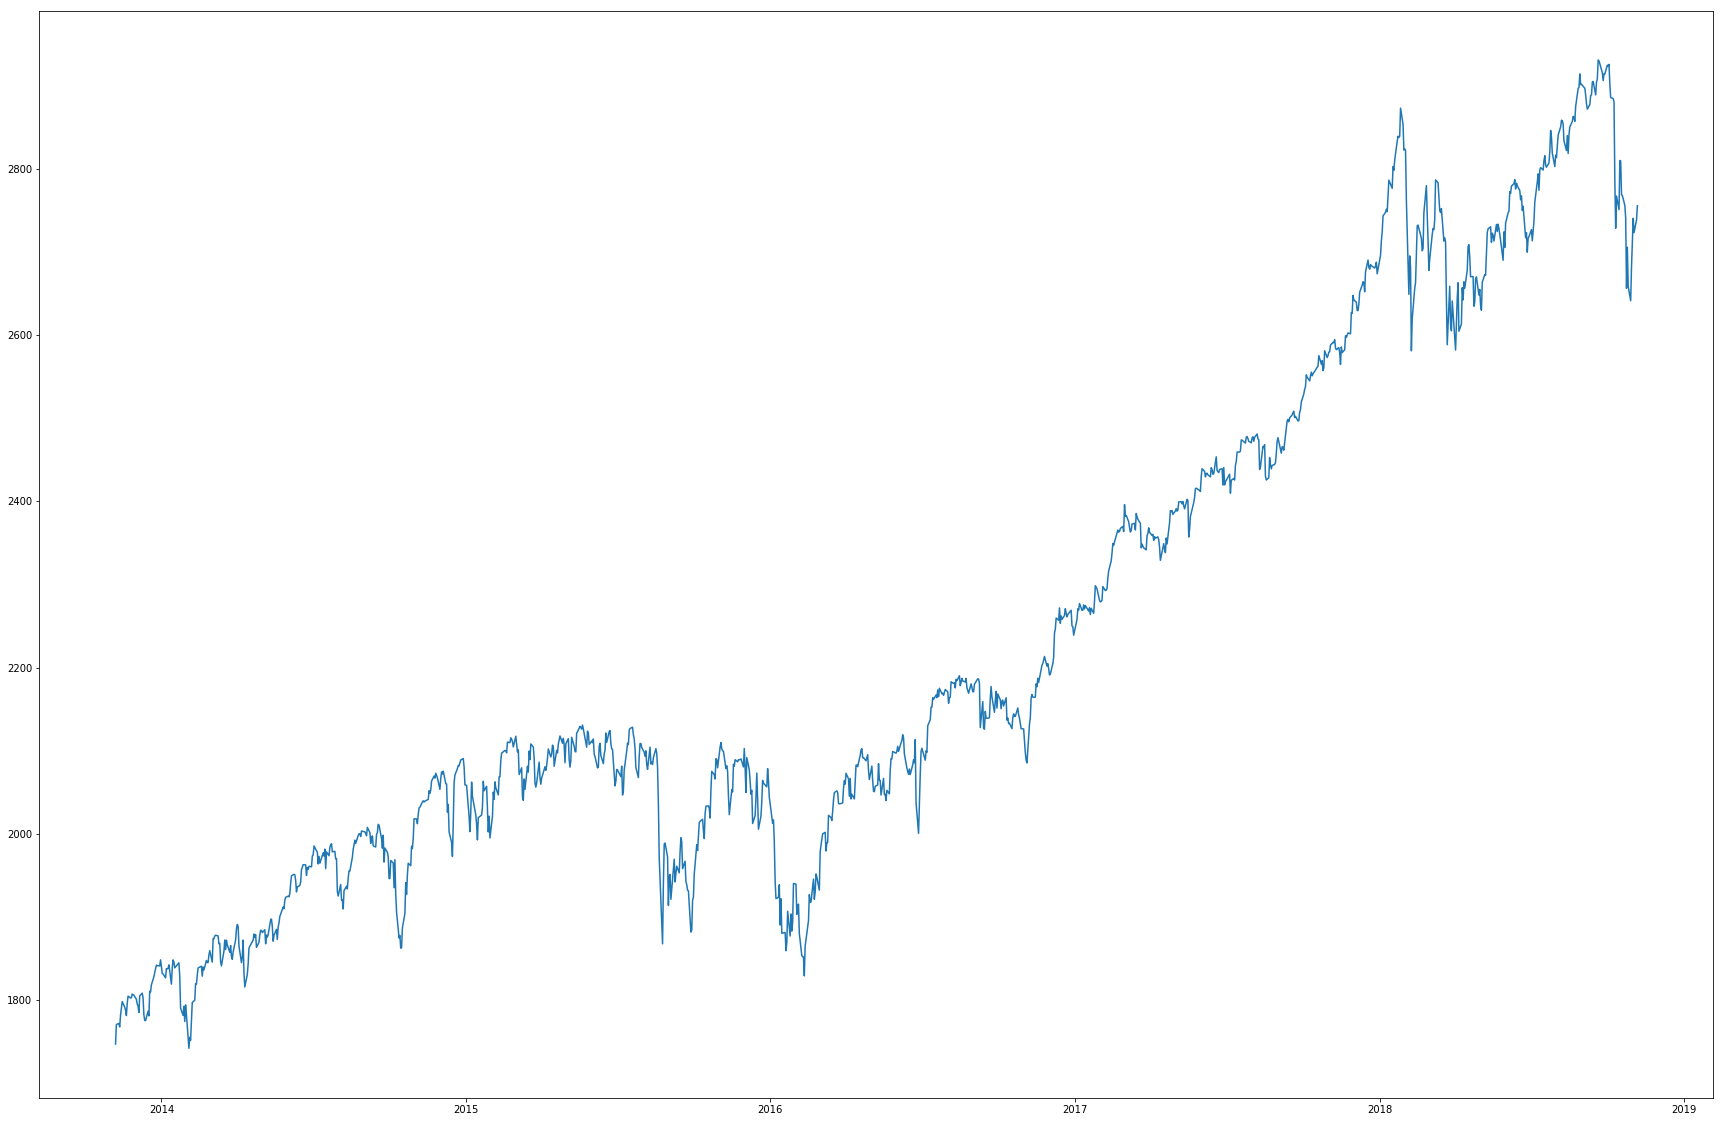

In [40]:
# Arrange the dataset in chronological order
spx = spx.sort_index(ascending=True, axis=0)
# Plot closing price as a function of time
plt.figure(figsize=(30,20))
plt.plot(spx['Close'])
plt.show()

## Moving average
Moving average is a commonly used indicator to predict stock price.  The price is predicted as equal to the average closing prices for previous set of n closing prices.  We will use only the date and close columns and apply moving average predict the stock price.  Typical random splitting as train and test set does not make sense on a time series data.  Hence we will split them as follows:  First 80% rows for training and last 20% for testing.

In [ ]:
df_for_analysis = pd.DataFrame(index=np.arange(len(spx)), columns=['Date', 'Close'])
df_for_analysis['Date'] = spx.index
df_for_analysis['Close'] = spx['Close'].values

In [42]:
df_for_analysis.head()

,Date,Close
0,2013-11-07,1747.150024
1,2013-11-08,1770.609985
2,2013-11-11,1771.890015
3,2013-11-12,1767.689941
4,2013-11-13,1782.000000


In [43]:
# Splilt into train and test
split_length = int(df_for_analysis.shape[0] * 0.8)
train = df_for_analysis.iloc[:split_length,:]
test = df_for_analysis.iloc[split_length:,:]

In [44]:
df_for_analysis.shape, train.shape, test.shape

((1259, 2), (1007, 2), (252, 2))

In [45]:
train['Date'].min(), train['Date'].max(), test['Date'].min(), test['Date'].max()

(Timestamp('2013-11-07 00:00:00'),
 Timestamp('2017-11-06 00:00:00'),
 Timestamp('2017-11-07 00:00:00'),
 Timestamp('2018-11-06 00:00:00'))

In [46]:
# Lets make predictions for the 
test['pred']  = df_for_analysis['Close'].rolling(window=252, center=False).mean().tail(252).values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
#  Let's determine the rmse using the moving average method
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test['Close'], test['pred']) ** 0.5
print(rmse)

185.06954074095864


In [48]:
#  rmse by itself does not give us much insight about model perforrmance
#  Let's plot the predictions vs the closing prices in the test set

In [49]:
# Define a function that plots the train, test and predictions that can be used with other prediction algorithms
def plot_preds(df_train, df_test):
    plt.figure(figsize=(20,10), frameon=False, dpi=100)
    plt.plot(df_train['Date'],df_train['Close'], color='green', alpha=0.5)
    plt.plot(df_test['Date'],df_test['Close'], color='blue')
    plt.plot(df_test['Date'],df_test['pred'], color='red')
    plt.legend(['Train', 'Test', 'Predicted'], fontsize=18)
    plt.grid(which='both')
    plt.show()    
    rmse = np.sqrt(np.mean(np.power((df_test['Close']-df_test['pred']),2)))
    print('RMSE = ' + str(rmse))
    

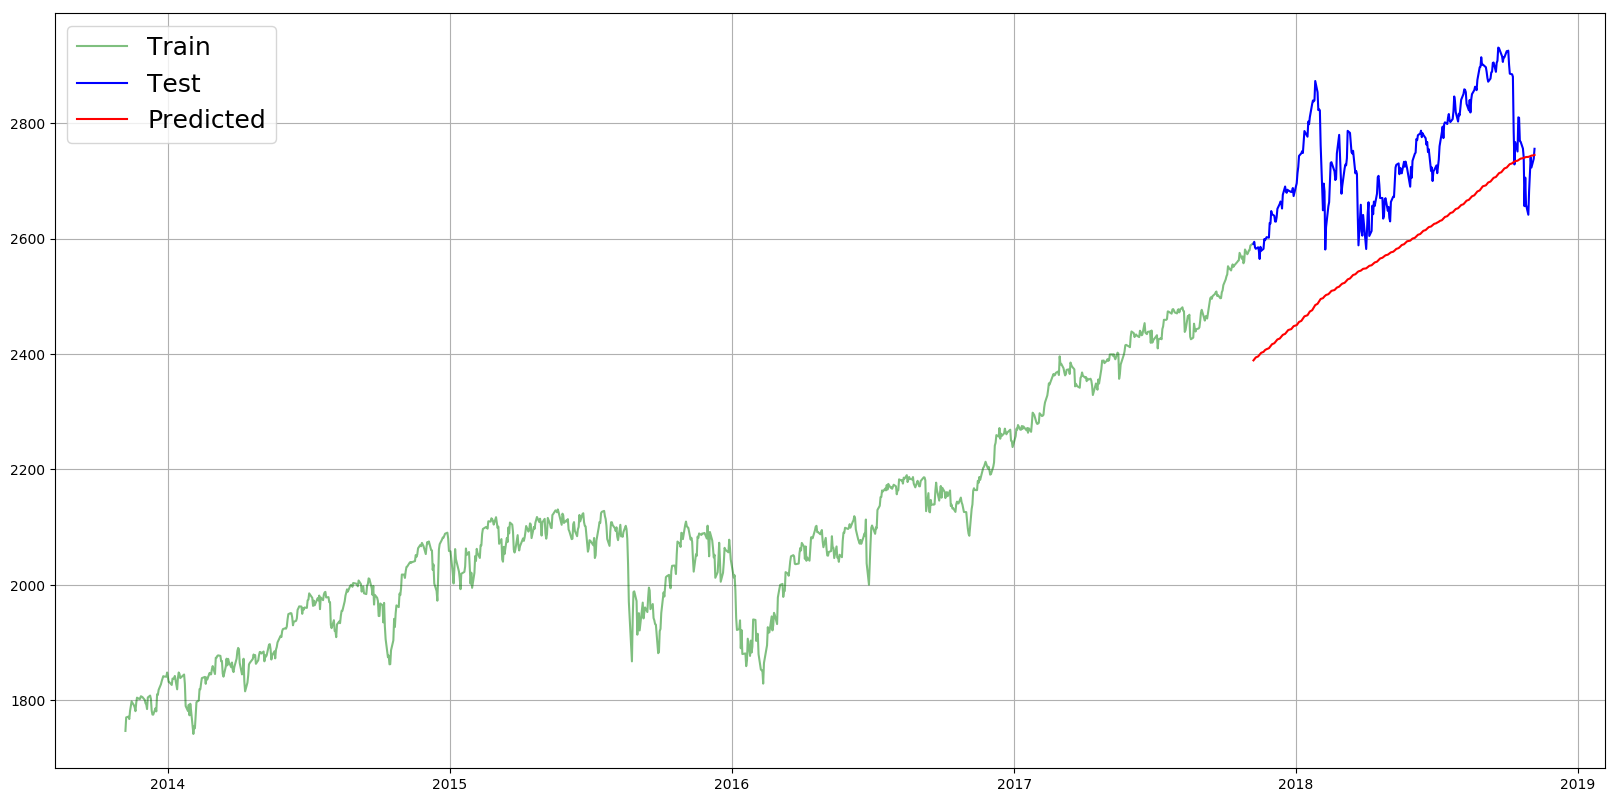

RMSE = 185.06954074095856


In [50]:
plot_preds(train, test)

# Moving average with a window length equal to test size, the results are not very promising

## Linear Regression

Linear Regression is one of the most simplest algorithm that can be implemented right out of the box to create some baseline predictions.  In this case, there is only one feature *Date*.  This can be broken down into several new relevant features like 
* *year*, 
* *month*, 
* *week*, 
* *day*, 
* *dayofweek*,  
* *dayofyear*, 
* *is_month_start*, 
* *is_month_end*, 
* *is_quarter_start*, 
* *is_quarter_end*, 
* *is_option_exp_week*

In [51]:
# Make sure the dates are in ascending order
df_for_analysis = df_for_analysis.sort_values('Date', ascending=True).reset_index(drop=True)

In [102]:
def get_date_features(df):
    '''
    Takes a dataframe with a column 'Date' and returns a dataframe with new feature columns
    added: year, month, dayofweek, dayofmonth, dayofyear, is_month_start, 
    is_month_end, is_quarter_start, is_quarter_end, is_option_ex_week
    '''
    df['year'] = df['Date'].apply(lambda x: x.strftime('%Y')).astype('int')
    df['month'] = df['Date'].apply(lambda x: x.strftime('%m')).astype('int')
    df['dayofweek'] = df['Date'].apply(lambda x: x.strftime('%w')).astype('int')
    df['dayofmonth'] = df['Date'].apply(lambda x: x.strftime('%d')).astype('int')
    df['dayofyear'] = df['Date'].apply(lambda x: x.strftime('%j')).astype('int')
    
    # Start of month is defined as first 7 days of month
    df['is_month_start'] = (df['dayofmonth'] <= 7).astype('int')
    
    # End of month is defined as last 7 days of month
    month_dict = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:30, 8:31, 9:30, 10:31, 11:30, 12:31}
    df['is_month_end'] = df[['dayofmonth', 'month']].apply(lambda x: x['dayofmonth'] >= (month_dict[x['month']]-7), axis=1).astype('int')
    
    #Quarter Start is defined as first 7 days of January, April, July and October
    df['is_quarter_start'] = (df['is_month_start'] & ((df['month']==1)|(df['month']==4)|(df['month']==7)|(df['month']==10))).astype('int')
    
    #Quarter end is defined as last 7 days of March, June, September, December
    df['is_quarter_end'] = (df['is_month_end'] & ((df['month']==3)|(df['month']==6)|(df['month']==9)|(df['month']==12))).astype('int')
    
    # Stock options expire third friday of every month.  The week in which third friday appears is called Option Expiration week
    # and this week tends to be volatile.
    df['is_option_ex_week'] = df[['dayofweek', 'dayofmonth']].apply(lambda x: (x['dayofweek']+10 <= x['dayofmonth']) & (x['dayofweek']+16 >= x['dayofmonth']), axis=1).astype('int')
    
    return df

In [95]:
df_for_analysis = get_date_features(df_for_analysis)

In [103]:
df_for_analysis.head()

,Date,Close,month,year,dayofweek,dayofmonth,dayofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_option_ex_week
0,2013-11-07,1747.150024,11,2013,4,7,311,1,0,0,0,0
1,2013-11-08,1770.609985,11,2013,5,8,312,0,0,0,0,0
2,2013-11-11,1771.890015,11,2013,1,11,315,0,0,0,0,1
3,2013-11-12,1767.689941,11,2013,2,12,316,0,0,0,0,1
4,2013-11-13,1782.000000,11,2013,3,13,317,0,0,0,0,1


In [104]:
df_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 12 columns):
Date                 1259 non-null datetime64[ns]
Close                1259 non-null float64
month                1259 non-null int32
year                 1259 non-null int32
dayofweek            1259 non-null int32
dayofmonth           1259 non-null int32
dayofyear            1259 non-null int32
is_month_start       1259 non-null int32
is_month_end         1259 non-null int32
is_quarter_start     1259 non-null int32
is_quarter_end       1259 non-null int32
is_option_ex_week    1259 non-null int32
dtypes: datetime64[ns](1), float64(1), int32(10)
memory usage: 68.9 KB


In [120]:
def create_train_test(df, train_ratio=0.8):
    split_length = int(df.shape[0] * train_ratio)
    
    train = df.iloc[:split_length,:]
    test = df.iloc[split_length:,:]
    
    X_train = train.drop(['Close', 'Date'], axis=1)
    y_train = train['Close']
    
    X_test = test.drop(['Close', 'Date'], axis=1)
    y_test = test['Close']
    
    return (train, test, X_train, y_train, X_test, y_test)

In [121]:
train, test, X_train, y_train, X_test, y_test = create_train_test(df_for_analysis, 0.75)

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [126]:
model = LinearRegression()
model.fit(X_train, y_train)
test['pred'] = model.predict(X_test)
rmse = mean_squared_error(y_test, test['pred']) ** 0.5
print(rmse)

273.67171617232714


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


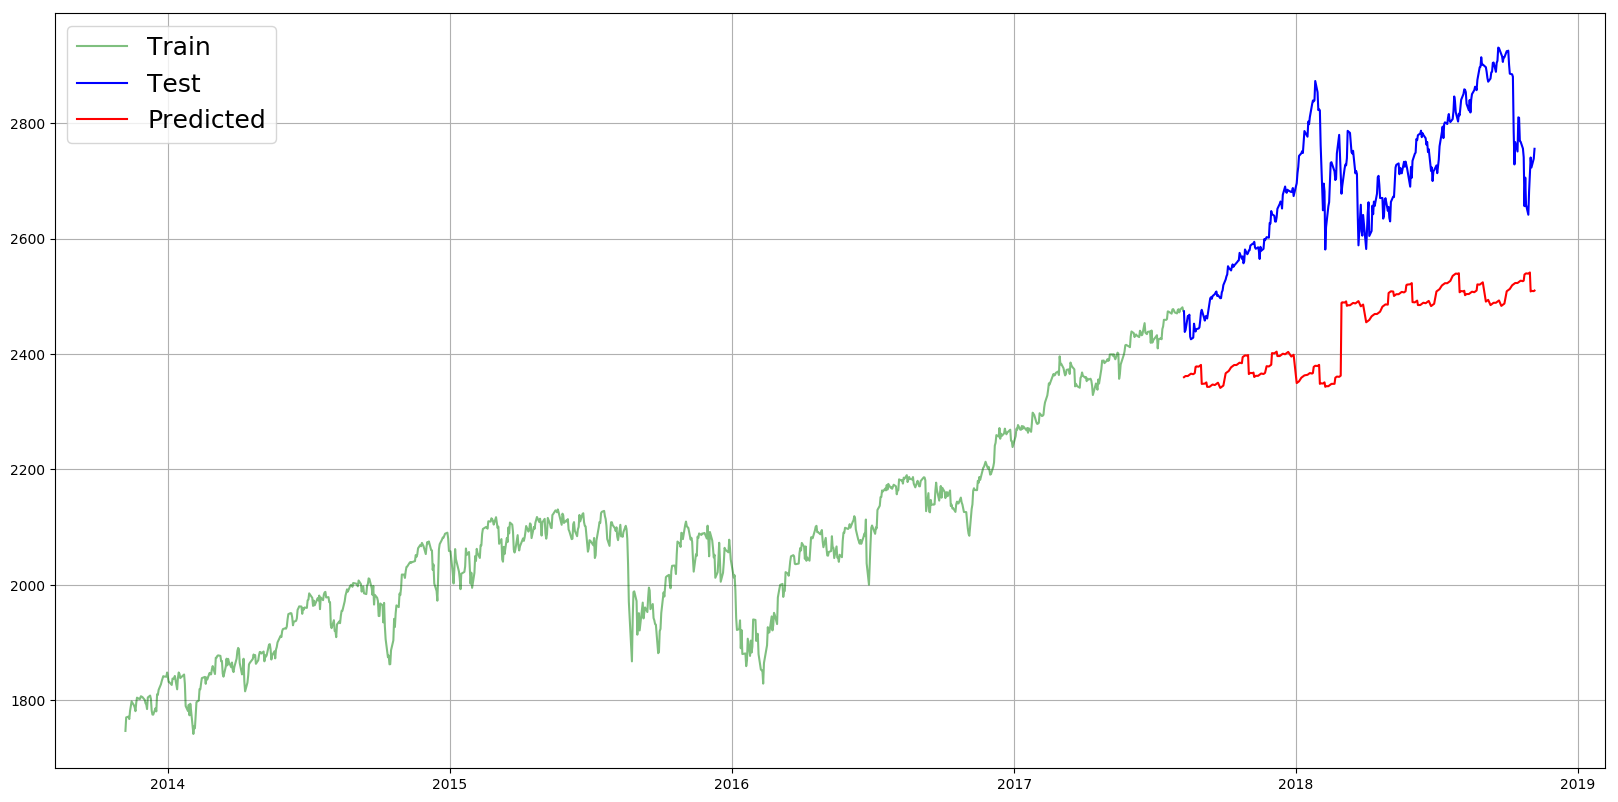

RMSE = 273.6717161723271


In [127]:
plot_preds(train, test)

In [131]:
model.coef_

array([ 1.60970279e+03,  1.42549262e+02,  4.96584682e-01,  5.29927057e+01,
       -5.24809756e+01,  8.66526415e+00,  9.50442740e+00, -1.53896842e+01,
       -1.80612596e+01,  4.56099500e-01])

In [129]:
X_train.columns

Index(['month', 'year', 'dayofweek', 'dayofmonth', 'dayofyear',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'is_option_ex_week'],
      dtype='object')

## Inference
Linear Regression model resulted in higher rmse than moving average. This is because LR overfits to month and year column.  Though and easy to interpret model, it is nowhere close to being useful.